In [1]:
import pandas as pd
import numpy as np
import datetime
from pandas_datareader.data import DataReader

In [2]:
from fredapi import Fred
import pandas as pd

# Fred api
fred = Fred(api_key="bde819bb46fac8116989ee870ee0a162")

# State FRED codes for unemployment (e.g., CAURN = California Unemployment Rate)
state_codes = {
    'Alabama': 'ALUR', 'Alaska': 'AKUR', 'Arizona': 'AZUR', 'Arkansas': 'ARUR',
    'California': 'CAUR', 'Colorado': 'COUR', 'Connecticut': 'CTUR', 'Delaware': 'DEUR',
    'Florida': 'FLUR', 'Georgia': 'GAUR', 'Hawaii': 'HIUR', 'Idaho': 'IDUR',
    'Illinois': 'ILUR', 'Indiana': 'INUR', 'Iowa': 'IAUR', 'Kansas': 'KSUR',
    'Kentucky': 'KYUR', 'Louisiana': 'LAUR', 'Maine': 'MEUR', 'Maryland': 'MDUR',
    'Massachusetts': 'MAUR', 'Michigan': 'MIUR', 'Minnesota': 'MNUR', 'Mississippi': 'MSUR',
    'Missouri': 'MOUR', 'Montana': 'MTUR', 'Nebraska': 'NEUR', 'Nevada': 'NVUR',
    'New Hampshire': 'NHUR', 'New Jersey': 'NJUR', 'New Mexico': 'NMUR', 'New York': 'NYUR',
    'North Carolina': 'NCUR', 'North Dakota': 'NDUR', 'Ohio': 'OHUR', 'Oklahoma': 'OKUR',
    'Oregon': 'ORUR', 'Pennsylvania': 'PAUR', 'Rhode Island': 'RIUR', 'South Carolina': 'SCUR',
    'South Dakota': 'SDUR', 'Tennessee': 'TNUR', 'Texas': 'TXUR', 'Utah': 'UTUR',
    'Vermont': 'VTUR', 'Virginia': 'VAUR', 'Washington': 'WAUR', 'West Virginia': 'WVUR',
    'Wisconsin': 'WIUR', 'Wyoming': 'WYUR'
}

# Fetch and build the dataset
unemp_data = pd.DataFrame()

for state, code in state_codes.items():
    try:
        series = fred.get_series(code)
        series.name = state
        unemp_data = pd.concat([unemp_data, series], axis=1)
    except Exception as e:
        print(f"Failed to get data for {state}: {e}")

# Set index as datetime
unemp_data.index = pd.to_datetime(unemp_data.index)
unemp_data.sort_index(inplace=True)

# Optional: Save to CSV
unemp_data.to_csv("Unemployment_by_State.csv")

# Preview
print(unemp_data.head())

            Alabama  Alaska  Arizona  Arkansas  California  Colorado  \
1976-01-01      6.7     7.1     10.2       7.3         9.2       5.8   
1976-02-01      6.6     7.1     10.2       7.3         9.2       5.8   
1976-03-01      6.6     7.0     10.2       7.3         9.1       5.7   
1976-04-01      6.5     7.0     10.0       7.2         9.0       5.6   
1976-05-01      6.4     7.0      9.8       7.1         8.9       5.6   

            Connecticut  Delaware  Florida  Georgia  ...  South Dakota  \
1976-01-01          9.7       8.0      9.6      8.4  ...           3.3   
1976-02-01          9.7       8.0      9.7      8.4  ...           3.3   
1976-03-01          9.7       8.0      9.6      8.3  ...           3.3   
1976-04-01          9.6       8.2      9.5      8.2  ...           3.2   
1976-05-01          9.4       8.4      9.3      8.1  ...           3.1   

            Tennessee  Texas  Utah  Vermont  Virginia  Washington  \
1976-01-01        6.0    5.8   5.8      8.5       6.0

In [3]:
import pandas as pd

# --- Load Zillow Data ---
zillow = pd.read_csv("Zillow_Data.csv")
zillow = zillow[zillow['RegionType'] == 'state']

# Keep only states also in unemployment data
unemp_data = pd.read_csv("Unemployment_by_State.csv", index_col=0, parse_dates=True)
common_states = list(set(zillow['RegionName']) & set(unemp_data.columns))
zillow = zillow[zillow['RegionName'].isin(common_states)]

# Melt Zillow to long format
zillow_melted = zillow.melt(id_vars=["RegionName"], var_name="Date", value_name="HomePrice")
zillow_melted["Date"] = pd.to_datetime(zillow_melted["Date"], errors='coerce')

# Align Zillow dates to first-of-month
zillow_melted["Date"] = zillow_melted["Date"].dt.to_period("M").dt.to_timestamp()

# Filter Zillow to match unemployment data's date range
zillow_melted = zillow_melted[zillow_melted["Date"] >= pd.to_datetime("2015-01-01")]

# --- Prepare Unemployment Data ---
unemp_long = unemp_data.reset_index().melt(id_vars="index", var_name="State", value_name="UnemploymentRate")
unemp_long = unemp_long.rename(columns={"index": "Date"})
unemp_long["Date"] = pd.to_datetime(unemp_long["Date"], errors='coerce')

# Drop any NaT dates
zillow_melted.dropna(subset=["Date"], inplace=True)
unemp_long.dropna(subset=["Date"], inplace=True)

# --- Merge the DataFrames ---
combined = pd.merge(
    zillow_melted,
    unemp_long,
    how="inner",
    left_on=["RegionName", "Date"],
    right_on=["State", "Date"]
)

# --- Preview ---
print("Merged shape:", combined.shape)
print(combined.head())

Merged shape: (6100, 5)
     RegionName       Date      HomePrice         State  UnemploymentRate
0    California 2015-01-01  412386.465825    California               6.8
1         Texas 2015-01-01  158901.150211         Texas               4.5
2       Florida 2015-01-01  179690.404533       Florida               5.9
3      New York 2015-01-01  235632.149261      New York               5.7
4  Pennsylvania 2015-01-01  154221.646536  Pennsylvania               5.5


C:\Users\rafid\AppData\Local\Temp\ipykernel_16264\2441800459.py:14: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  zillow_melted["Date"] = pd.to_datetime(zillow_melted["Date"], errors='coerce')


In [4]:
from sklearn.preprocessing import MinMaxScaler

# Make a copy for scoring
score_df = combined.copy()

# Normalize HomePrice and UnemploymentRate
scaler = MinMaxScaler()
score_df[['PriceNorm', 'UnempNorm']] = scaler.fit_transform(score_df[['HomePrice', 'UnemploymentRate']])

# Lower values are better for both, so we invert the normalized scores
score_df['DesirabilityScore'] = (1 - score_df['PriceNorm']) * 0.6 + (1 - score_df['UnempNorm']) * 0.4

# Preview top states by lowest DesirabilityScore (higher is better)
print(score_df.sort_values('DesirabilityScore', ascending=False).head(10))

     RegionName       Date      HomePrice     State  UnemploymentRate  \
2127   Oklahoma 2018-07-01  128950.087568  Oklahoma               3.1   
2177   Oklahoma 2018-08-01  129143.976783  Oklahoma               3.1   
2227   Oklahoma 2018-09-01  129593.094904  Oklahoma               3.1   
2277   Oklahoma 2018-10-01  129940.294306  Oklahoma               3.1   
2077   Oklahoma 2018-06-01  128833.196719  Oklahoma               3.2   
36     Nebraska 2015-01-01  135376.014432  Nebraska               2.9   
2627   Oklahoma 2019-05-01  133550.627991  Oklahoma               3.0   
86     Nebraska 2015-02-01  135881.500599  Nebraska               2.9   
2677   Oklahoma 2019-06-01  134087.241111  Oklahoma               3.0   
136    Nebraska 2015-03-01  136401.674388  Nebraska               2.9   

      PriceNorm  UnempNorm  DesirabilityScore  
2127   0.031197   0.048611           0.961838  
2177   0.031414   0.048611           0.961707  
2227   0.031916   0.048611           0.961406  
2277

In [5]:
state_scores = score_df.groupby("RegionName")["DesirabilityScore"].mean().sort_values(ascending=False)
print(state_scores.head(10))

RegionName
Oklahoma         0.934623
West Virginia    0.933539
Iowa             0.931806
Kansas           0.929663
Arkansas         0.929088
Kentucky         0.922906
Mississippi      0.922353
Nebraska         0.922092
Alabama          0.919791
Indiana          0.919335
Name: DesirabilityScore, dtype: float64


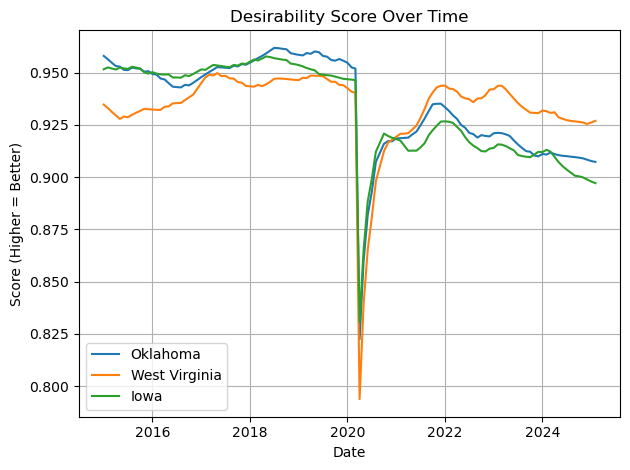

In [6]:
import matplotlib.pyplot as plt

top_states = state_scores.head(3).index
for state in top_states:
    state_data = score_df[score_df['RegionName'] == state]
    plt.plot(state_data['Date'], state_data['DesirabilityScore'], label=state)

plt.title("Desirability Score Over Time")
plt.ylabel("Score (Higher = Better)")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [7]:
def recommend_states(df, start_date, end_date, price_weight=0.6, unemp_weight=0.4, top_n=5):
    # Filter date range
    mask = (df['Date'] >= pd.to_datetime(start_date)) & (df['Date'] <= pd.to_datetime(end_date))
    filtered = df[mask].copy()

    # Recompute score with custom weights
    filtered['CustomScore'] = (1 - filtered['PriceNorm']) * price_weight + \
                              (1 - filtered['UnempNorm']) * unemp_weight

    # Group by state and average score
    recommendations = filtered.groupby("RegionName")['CustomScore'].mean().sort_values(ascending=False).head(top_n)

    return recommendations.reset_index()

In [8]:
# Recommend top 5 states from 2020 to 2022 with equal weight
top_states = recommend_states(score_df, start_date="2020-01-01", end_date="2022-12-31", price_weight=0.5, unemp_weight=0.5, top_n=5)
print(top_states)

  RegionName  CustomScore
0     Kansas     0.917024
1   Nebraska     0.916666
2   Oklahoma     0.916573
3       Iowa     0.916365
4   Arkansas     0.912056


In [9]:
# --- Get Total Nonfarm Payroll Employment (Monthly) ---
jobs = fred.get_series("PAYEMS")  # Correct FRED ID for U.S. Total Nonfarm Jobs
jobs = jobs.resample("M").mean()
jobs = jobs.to_frame(name="US_Nonfarm_Jobs")

# --- Calculate Monthly Job Growth Rate (%) ---
jobs["JobGrowthRate"] = jobs["US_Nonfarm_Jobs"].pct_change() * 100

# --- Prepare for Merge ---
jobs.reset_index(inplace=True)
jobs.rename(columns={"index": "Date"}, inplace=True)

# --- Align both 'Date' columns to first of the month ---
# Align both Date columns to first-of-month format
combined["Date"] = pd.to_datetime(combined["Date"]).dt.to_period("M").dt.to_timestamp()
jobs["Date"] = pd.to_datetime(jobs["Date"]).dt.to_period("M").dt.to_timestamp()

# --- Merge with Zillow + Unemployment Data ---
combined = pd.merge(combined, jobs, on="Date", how="left")

# --- Preview ---
print("Combined shape with Job Growth:", combined.shape)
print(combined[["Date", "RegionName", "HomePrice", "UnemploymentRate", "JobGrowthRate"]].dropna().head())

Combined shape with Job Growth: (6100, 7)
        Date    RegionName      HomePrice  UnemploymentRate  JobGrowthRate
0 2015-01-01    California  412386.465825               6.8       0.145336
1 2015-01-01         Texas  158901.150211               4.5       0.145336
2 2015-01-01       Florida  179690.404533               5.9       0.145336
3 2015-01-01      New York  235632.149261               5.7       0.145336
4 2015-01-01  Pennsylvania  154221.646536               5.5       0.145336


C:\Users\rafid\AppData\Local\Temp\ipykernel_16264\2919321574.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  jobs = jobs.resample("M").mean()


In [10]:
from sklearn.preprocessing import MinMaxScaler

# Normalize each metric
scaler = MinMaxScaler()

score_df = combined.copy()
score_df[['PriceNorm', 'UnempNorm', 'JobGrowthNorm']] = scaler.fit_transform(
    score_df[['HomePrice', 'UnemploymentRate', 'JobGrowthRate']]
)

# Compute a desirability score: higher = better
score_df['DesirabilityScore'] = (
    (1 - score_df['PriceNorm']) * 0.5 +   # lower home price is better
    (1 - score_df['UnempNorm']) * 0.3 +   # lower unemployment is better
    (score_df['JobGrowthNorm']) * 0.2     # higher job growth is better
)

# Sort or preview
top_states = score_df.sort_values('DesirabilityScore', ascending=False)
print(top_states[['Date', 'RegionName', 'DesirabilityScore']].head())

           Date RegionName  DesirabilityScore
3275 2020-06-01   Kentucky           0.937670
2177 2018-08-01   Oklahoma           0.930911
2277 2018-10-01   Oklahoma           0.929746
2077 2018-06-01   Oklahoma           0.929731
2027 2018-05-01   Oklahoma           0.929493


In [11]:
scaler = MinMaxScaler()
combined[["PriceNorm", "UnempNorm", "JobGrowthNorm"]] = scaler.fit_transform(
    combined[["HomePrice", "UnemploymentRate", "JobGrowthRate"]]
)

combined["DesirabilityScore"] = (
    (1 - combined["PriceNorm"]) * 0.5 +
    (1 - combined["UnempNorm"]) * 0.2 +
    combined["JobGrowthNorm"] * 0.3
)

In [12]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from fredapi import Fred

# --- Load Zillow Data ---
zillow = pd.read_csv("Zillow_Data.csv")
zillow = zillow[zillow['RegionType'] == 'state']

# --- Download unemployment data from FRED ---
fred = Fred(api_key="bde819bb46fac8116989ee870ee0a162")

# Unemployment data for each state
state_codes = {
    'Alabama': 'ALUR', 'Alaska': 'AKUR', 'Arizona': 'AZUR', 'Arkansas': 'ARUR',
    'California': 'CAUR', 'Colorado': 'COUR', 'Connecticut': 'CTUR', 'Delaware': 'DEUR',
    'Florida': 'FLUR', 'Georgia': 'GAUR', 'Hawaii': 'HIUR', 'Idaho': 'IDUR',
    'Illinois': 'ILUR', 'Indiana': 'INUR', 'Iowa': 'IAUR', 'Kansas': 'KSUR',
    'Kentucky': 'KYUR', 'Louisiana': 'LAUR', 'Maine': 'MEUR', 'Maryland': 'MDUR',
    'Massachusetts': 'MAUR', 'Michigan': 'MIUR', 'Minnesota': 'MNUR', 'Mississippi': 'MSUR',
    'Missouri': 'MOUR', 'Montana': 'MTUR', 'Nebraska': 'NEUR', 'Nevada': 'NVUR',
    'New Hampshire': 'NHUR', 'New Jersey': 'NJUR', 'New Mexico': 'NMUR', 'New York': 'NYUR',
    'North Carolina': 'NCUR', 'North Dakota': 'NDUR', 'Ohio': 'OHUR', 'Oklahoma': 'OKUR',
    'Oregon': 'ORUR', 'Pennsylvania': 'PAUR', 'Rhode Island': 'RIUR', 'South Carolina': 'SCUR',
    'South Dakota': 'SDUR', 'Tennessee': 'TNUR', 'Texas': 'TXUR', 'Utah': 'UTUR',
    'Vermont': 'VTUR', 'Virginia': 'VAUR', 'Washington': 'WAUR', 'West Virginia': 'WVUR',
    'Wisconsin': 'WIUR', 'Wyoming': 'WYUR'
}

unemp_data = pd.DataFrame()

for state, code in state_codes.items():
    try:
        series = fred.get_series(code)
        series.name = state
        unemp_data = pd.concat([unemp_data, series], axis=1)
    except:
        print(f"❌ Failed to load: {state} ({code})")

unemp_data.index = pd.to_datetime(unemp_data.index)
unemp_data = unemp_data.resample("MS").mean()

# --- Match Zillow states ---
common_states = list(set(zillow['RegionName']) & set(unemp_data.columns))
zillow = zillow[zillow['RegionName'].isin(common_states)]

# --- Transform Zillow data ---
zillow_melted = zillow.melt(id_vars=["RegionName"], var_name="Date", value_name="HomePrice")
zillow_melted["Date"] = pd.to_datetime(zillow_melted["Date"], errors='coerce')
zillow_melted["Date"] = zillow_melted["Date"].dt.to_period("M").dt.to_timestamp()
zillow_melted = zillow_melted[zillow_melted["Date"] >= pd.to_datetime("2015-01-01")]

# --- Prepare Unemployment Data ---
unemp_long = unemp_data.reset_index().melt(id_vars="index", var_name="State", value_name="UnemploymentRate")
unemp_long = unemp_long.rename(columns={"index": "Date"})
unemp_long["Date"] = pd.to_datetime(unemp_long["Date"], errors='coerce')
zillow_melted.dropna(subset=["Date"], inplace=True)
unemp_long.dropna(subset=["Date"], inplace=True)

# --- Merge Zillow & Unemployment ---
combined = pd.merge(zillow_melted, unemp_long, how="inner",
                    left_on=["RegionName", "Date"],
                    right_on=["State", "Date"])

# --- Add Job Growth (FRED) ---
jobs = fred.get_series("PAYEMS")  # US total nonfarm payrolls
jobs = jobs.resample("MS").mean()
jobs = jobs.to_frame(name="US_Nonfarm_Jobs")
jobs["JobGrowthRate"] = jobs["US_Nonfarm_Jobs"].pct_change() * 100
jobs.reset_index(inplace=True)
jobs.rename(columns={"index": "Date"}, inplace=True)

combined = pd.merge(combined, jobs[["Date", "JobGrowthRate"]], on="Date", how="left")

# --- Add Dummy Affordability Metric (Price-to-Rent Ratio) ---
combined["PriceToRentRatio"] = combined["HomePrice"] / 20000  # Placeholder rent value

# --- Normalize and Score ---
scaler = MinMaxScaler()
combined[["PriceNorm", "UnempNorm", "JobGrowthNorm", "AffordabilityNorm"]] = scaler.fit_transform(
    combined[["HomePrice", "UnemploymentRate", "JobGrowthRate", "PriceToRentRatio"]]
)

combined["DesirabilityScore"] = (
    (1 - combined["PriceNorm"]) * 0.4 +
    (1 - combined["UnempNorm"]) * 0.2 +
    combined["JobGrowthNorm"] * 0.2 +
    (1 - combined["AffordabilityNorm"]) * 0.2

)

combined["Bedrooms"] = np.random.randint(1, 6, size=len(combined))  # Between 1–5
combined["PriceToIncomeRatio"] = combined["HomePrice"] / 65000  # Example income

# --- Automatically Save for Streamlit ---
combined.to_csv("combined_data.csv", index=False)
print("✅ combined_data.csv saved successfully.")

C:\Users\rafid\AppData\Local\Temp\ipykernel_16264\3257065221.py:48: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  zillow_melted["Date"] = pd.to_datetime(zillow_melted["Date"], errors='coerce')


✅ combined_data.csv saved successfully.


In [13]:
import pandas as pd

# Load all 3 datasets
combined = pd.read_csv("combined_data.csv")
crime_df = pd.read_csv("crime_by_state.csv")
school_df = pd.read_csv("school_index.csv")

# Strip whitespace and fix any inconsistent columns
combined.columns = combined.columns.str.strip()
crime_df.columns = crime_df.columns.str.strip()
school_df.columns = school_df.columns.str.strip()

# Select and rename relevant school columns
school_df_clean = school_df[["State", "SCHL_IDX"]].copy()
school_df_clean.rename(columns={"SCHL_IDX": "SchoolRating"}, inplace=True)

# Optional: average school score per state (since school data is by tract)
school_df_agg = school_df_clean.groupby("State", as_index=False).mean()

# Merge both datasets
combined = combined.merge(crime_df[["State", "Murder", "Assault", "Rape"]], on="State", how="left")
combined = combined.merge(school_df_agg, on="State", how="left")

# Save to new enriched file
combined.to_csv("combined_data_enriched.csv", index=False)

In [14]:
df=pd.read_csv("combined_data_enriched.csv")
df.head()

,RegionName,Date,HomePrice,State,UnemploymentRate,JobGrowthRate,PriceToRentRatio,PriceNorm,UnempNorm,JobGrowthNorm,AffordabilityNorm,DesirabilityScore,Bedrooms,PriceToIncomeRatio,Murder,Assault,Rape,SchoolRating
0,California,2015-01-01,412386.465825,California,6.8,0.145336,20.619323,0.348255,0.177083,0.804334,0.348255,0.716497,4,6.344407,9.0,276,40.6,49.499310
1,Texas,2015-01-01,158901.150211,Texas,4.5,0.145336,7.945058,0.064701,0.097222,0.804334,0.064701,0.902602,5,2.444633,12.7,201,25.5,49.501835
2,Florida,2015-01-01,179690.404533,Florida,5.9,0.145336,8.984520,0.087956,0.145833,0.804334,0.087956,0.878927,2,2.764468,15.4,335,31.9,49.504032
3,New York,2015-01-01,235632.149261,New York,5.7,0.145336,11.781607,0.150534,0.138889,0.804334,0.150534,0.842769,2,3.625110,11.1,254,26.1,49.503275
4,Pennsylvania,2015-01-01,154221.646536,Pennsylvania,5.5,0.145336,7.711082,0.059466,0.131944,0.804334,0.059466,0.898798,5,2.372641,6.3,106,14.9,49.503310


In [15]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Load your enriched CSV
df = pd.read_csv("combined_data_enriched.csv")

# Calculate composite crime rate
df["CrimeRateRaw"] = df[["Murder", "Assault", "Rape"]].sum(axis=1)

# Normalize to scale of 1–10
scaler = MinMaxScaler(feature_range=(1, 10))
df["CrimeRate"] = scaler.fit_transform(df[["CrimeRateRaw"]])

# Save updated version
df.to_csv("combined_data_final.csv", index=False)

In [16]:
%%writefile nestor_app.py
import streamlit as st
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# --- Load and Prepare Data ---
@st.cache_data
def load_data():
    df = pd.read_csv("combined_data_final.csv", parse_dates=["Date"])
        # Simulate Healthcare Access (1–10) if missing
    if "HealthcareAccess" not in df.columns:
        np.random.seed(42)  # For reproducibility
        df["HealthcareAccess"] = np.random.uniform(1, 10, size=len(df)).round(1)
    
    # Calculate CrimeRate from component crimes
    df["CrimeRateRaw"] = df[["Murder", "Assault", "Rape"]].sum(axis=1)

    # Normalize CrimeRate and SchoolRating to scale 1–10
    scaler = MinMaxScaler(feature_range=(1, 10))
    df["CrimeRate"] = scaler.fit_transform(df[["CrimeRateRaw"]])
    df["SchoolRating"] = scaler.fit_transform(df[["SchoolRating"]])

    return df

data = load_data()

# --- Sidebar: Filter Mode Selection ---
st.sidebar.header("Your Preferences")
filter_mode = st.sidebar.radio("Filter by:", ["Budget", "Bedrooms", "Crime Rate", "Healthcare Access"])

# --- Sidebar: Dynamic Filters ---
if filter_mode == "Budget":
    min_price = st.sidebar.number_input("Min Budget ($)", value=100000)
    max_price = st.sidebar.number_input("Max Budget ($)", value=800000)
    school_rating = st.sidebar.slider("Minimum School Rating (1–10)", 1.0, 10.0, 7.0)

    filtered = data[
        (data["HomePrice"] >= min_price) &
        (data["HomePrice"] <= max_price) &
        (data["SchoolRating"] >= school_rating)
    ]
    display_cols = ["RegionName", "Date", "HomePrice", "SchoolRating", "CrimeRate", "DesirabilityScore"]

elif filter_mode == "Bedrooms":
    bedrooms = st.sidebar.slider("Preferred # of Bedrooms", 1, 5, 3)
    school_rating = st.sidebar.slider("Minimum School Rating (1–10)", 1.0, 10.0, 7.0)

    if "Bedrooms" in data.columns:
        filtered = data[
            (data["Bedrooms"] == bedrooms) &
            (data["SchoolRating"] >= school_rating)
        ]
        display_cols = ["RegionName", "Date", "Bedrooms", "SchoolRating", "CrimeRate", "DesirabilityScore"]
    else:
        st.warning("⚠️ 'Bedrooms' data not available.")
        filtered = data[0:0]
        display_cols = []

elif filter_mode == "Crime Rate":
    max_crime = st.sidebar.slider("Max Acceptable Crime Rate (1–10)", 1.0, 10.0, 5.0)
    school_rating = st.sidebar.slider("Minimum School Rating (1–10)", 1.0, 10.0, 7.0)

    filtered = data[
        (data["CrimeRate"] <= max_crime) &
        (data["SchoolRating"] >= school_rating)
    ]
    display_cols = ["RegionName", "Date", "CrimeRate", "SchoolRating", "DesirabilityScore"]

elif filter_mode == "Healthcare Access":
    min_healthcare = st.sidebar.slider("Minimum Healthcare Access (1–10)", 1.0, 10.0, 7.0)
    school_rating = st.sidebar.slider("Minimum School Rating (1–10)", 1.0, 10.0, 7.0)

    if "HealthcareAccess" in data.columns:
        filtered = data[
            (data["HealthcareAccess"] >= min_healthcare) &
            (data["SchoolRating"] >= school_rating)
        ]
        display_cols = ["RegionName", "Date", "HealthcareAccess", "SchoolRating", "CrimeRate", "DesirabilityScore"]
    else:
        st.warning("⚠️ 'HealthcareAccess' data not available.")
        filtered = data[0:0]
        display_cols = []

# --- Main Content ---
st.title(" Nestor: Smart Home State Recommendations")
st.markdown("### Best States to Consider Based on Economic & Housing Metrics")

# Top pick
if not filtered.empty:
    top_row = filtered.sort_values("DesirabilityScore", ascending=False).iloc[0]
    st.success(f" **Top Pick: {top_row['RegionName']}** — Score: {top_row['DesirabilityScore']:.3f}")

# Result table
st.markdown(f"### {len(filtered)} Matching Results")
if display_cols:
    st.dataframe(filtered.sort_values("DesirabilityScore", ascending=False)[display_cols])

# Bar chart: Top 5 by Desirability
if not filtered.empty and "RegionName" in filtered.columns:
    top5 = filtered.sort_values("DesirabilityScore", ascending=False).head(5)
    st.markdown("### Top Region(s) by Desirability Score")
    st.bar_chart(top5.set_index("RegionName")["DesirabilityScore"])

# Line chart: Price Trends Over Time for Top Regions
if not filtered.empty and "RegionName" in filtered.columns:
    top5_regions = top5["RegionName"].unique()
    trend_data = data[data["RegionName"].isin(top5_regions)]

    st.markdown("### 📈 Price Trends Over Time for Top Regions")
    st.line_chart(
        trend_data.pivot_table(index="Date", columns="RegionName", values="HomePrice")
    )


# Download results
if not filtered.empty:
    st.download_button(
        label="📥 Download Results as CSV",
        data=filtered.to_csv(index=False),
        file_name="nestor_recommendations.csv",
        mime="text/csv"
    )
with st.expander("About the Desirability Score"):
    st.markdown("""
    The Desirability Score is a composite of:
    - Home affordability
    - Unemployment rate
    - Job growth
    - School quality
    - Crime rate (lower is better)
    - Healthcare access (simulated for demonstration)
    
    Data sources include HUD, FBI, FRED, and public housing statistics.
    """)

Overwriting nestor_app.py


#### run
streamlit run nestor_app.py